# Hate speech classification

Labelled Twitter data

## Install our preprocessing package

In [2]:
!python -m pip install git+https://git@github.com/lvsuno/Text-preprocessing.git

  Cloning https://****@github.com/lvsuno/Text-preprocessing.git to /private/var/folders/7v/syzn01012_3fnr7bzfw4zzl40000gp/T/pip-req-build-p2igynnt
  Running command git clone --filter=blob:none --quiet 'https://****@github.com/lvsuno/Text-preprocessing.git' /private/var/folders/7v/syzn01012_3fnr7bzfw4zzl40000gp/T/pip-req-build-p2igynnt
  Resolved https://****@github.com/lvsuno/Text-preprocessing.git to commit c17e60a4fae6b70b9247760daa05248fcc981b7b
  Preparing metadata (setup.py) ... done


In [88]:
import numpy as np 
import pandas as pd 
import re
from sklearn.model_selection import train_test_split
import preprocess_lvsuno as pl
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding
from tensorflow.keras.layers import Dropout, Conv1D, MaxPool1D, GlobalMaxPooling1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils




In [64]:
df = pd.read_csv('data/speech_data.csv', index_col=0)

In [65]:
vc = df['class'].value_counts()
index = list(vc.index)
count = min(vc.values)

## Prepocess the data
* Balance the data
* put the text to lowercase, expand contractions, remove emails, urls, html tags, Retweets, accented  or special characters, repeated characters

In [66]:
df_bal = pd.DataFrame()
for i in index:
    temp = df[df['class']==i].sample(count)
    df_bal = pd.concat([df_bal, temp], ignore_index=True)

In [67]:
df = df_bal.copy()

In [68]:
df['class'].value_counts()

1    1430
2    1430
0    1430
Name: class, dtype: int64

In [69]:
def pre_pro(x):
    x = str(x).lower().replace('\\',' ').replace('_',' ')
    x = pl.cont_exp(x)
    x = pl.remove_emails(x)
    x = pl.remove_urls(x)
    x = pl.remove_html_tags(x)
    x = pl.remove_rt(x)
    x = pl.remove_accented_chars(x)
    x = pl.remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x

In [70]:
df['tweet'] = df['tweet'].apply(lambda x: pre_pro(x))

/Users/elvist/miniconda3/envs/tensorflow/lib/python3.10/site-packages/preprocess_lvsuno/utils.py:170: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(x, 'lxml').get_text().strip()


### Text Tokenization

In [71]:
text = df['tweet'].tolist()

In [72]:
token = Tokenizer()
token.fit_on_texts(text)

In [76]:
vocab_size = len(token.word_counts)+1
encoded_text = token.texts_to_sequences(text)

In [81]:
max_length = 120
X = pad_sequences(encoded_text, maxlen=max_length, padding='post')
y = np_utils.to_categorical(df['class'])

* Split into train and test sets

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

## Buil the model

In [83]:
vec_size = 300
model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length))

model.add(Conv1D(32, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(3, activation='softmax'))

2023-03-31 19:28:13.760909: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-31 19:28:13.761690: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



In [84]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [87]:
model.fit(X_train, y_train, epochs=2, validation_data=(X_test, y_test), shuffle=True)

Epoch 1/2
108/108 [==============================] - 4s 37ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.2649 - val_accuracy: 0.7517
Epoch 2/2
108/108 [==============================] - 4s 37ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 1.3431 - val_accuracy: 0.7389


In [89]:
y_pred = np.argmax(model.predict(X_test), axis=-1)

20/27 [=====================>........] - ETA: 0s

2023-03-31 19:35:51.724184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 0s 7ms/step


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

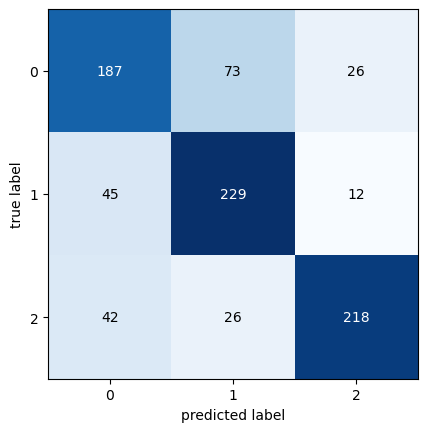

In [90]:
plot_confusion_matrix(confusion_matrix(np.argmax(y_test, axis=-1), y_pred))


In [91]:
print(classification_report(np.argmax(y_test, axis=-1), y_pred))

              precision    recall  f1-score   support

           0       0.68      0.65      0.67       286
           1       0.70      0.80      0.75       286
           2       0.85      0.76      0.80       286

    accuracy                           0.74       858
   macro avg       0.74      0.74      0.74       858
weighted avg       0.74      0.74      0.74       858



In [92]:
# Save the tokens and the model
model.save('models/model_hate_speech.h5')

In [93]:
import pickle
pickle.dump(token, open('data/token.pkl', 'wb'))